# RLC Fitting 

Created on Wed Jul 18 14:34:18 2018

@author: ericmuckley@gmail.com

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit

from sark110 import *

## Functions

In [30]:

ls = 16
def label_axes(xlabel='x', ylabel='y', size=ls):
    #set axes labels and size
    plt.rcParams['xtick.labelsize'] = size 
    plt.rcParams['ytick.labelsize'] = size
    plt.xlabel(str(xlabel), fontsize=size)
    plt.ylabel(str(ylabel), fontsize=size)



def get_conductance(rs, xs):
    # calculates series conductance from Rs and Xs
    #complex impedance    
    Z = np.add(rs, 1j*xs)
    #complex admittance
    Y = np.reciprocal(Z)
    #conductance
    G = np.real(Y)
    #susceptance
    B = np.imag(Y)

    return G



def get_f_range(band_cent, band_points=750, bandwidth=50000):
    # construct range of frequencies usuing center frequency (band_cent),
    # total number of points in the band (bandpoints), and
    # total bandwidth in Hz (bandwidth)
    df = np.linspace(0, int(bandwidth), int(band_points)) - int(bandwidth/2)
    f_range = np.add(band_cent, df).astype(int)
    return f_range



def remove_outliers(spectra, num_of_outliers=6):
    # removes outlier points caused by poor buffering/sampling by SARK-110 
    spectra2 = np.copy(spectra)
    #replace lowest outlier points with average of adjacent points
    for i in range(num_of_outliers):  
        #find index of minimum point
        min_index = np.argmin(spectra2)
        #make sure minimum is not first or last point
        if min_index != 0 and min_index != len(spectra2)-1:
            #convert minimum point into average of its neighboring points
            spectra2[min_index] = (
                    spectra2[min_index-1] + spectra2[min_index+1]) / 2
    return spectra2



def single_lorentz(freq, Gp, Cp, Gmax, D0, f0):
    # Returns conductance spectrum with single peak.
    # Spectrum calculation is taken from Equation (2) in:
    # Yoon, S.M., Cho, N.J. and Kanazawa, K., 2009. Analyzing spur-distorted 
    # impedance spectra for the QCM. Journal of Sensors, 2009.
    # Gp = parallel conductance offset
    # Cp = parallel susceptance offset
    # Gmax = maximum of conductance peak
    # D0 = dissipation
    # f0 = resonant frequency of peak (peak position) 
    #construct peak
    peak = Gmax / (1 + (1j/D0)*((freq/f0)-(f0/freq)))
    #add parallel offsets to peak
    Y = Gp + 1j*2*np.pi*freq*Cp + peak
    G = np.real(Y)
    return G


def single_RLC(fit_params0):
    # calculate equivalent circuit parameters from RLC fits
    # from Yoon et al., Analyzing Spur-Distorted Impedance 
    # Spectra for the QCM, Eqn. 3.
    #FIT PARAMS = [Gp, Cp, Gmax0, D0, f0]
    G0 = fit_params0[2]
    f0 = fit_params0[4]
    D0 = fit_params0[3]
    R = 1/G0
    L = 1 / (2 * np.pi * f0 * D0 * G0)
    C = 1 / (4 * np.pi**2 * f0**2 * L)
    return R, L, C

## User inputs

In [31]:
#input fundamental crystal resonance in Hz
crystal_res = 10000000
band_cent0 = int(0.999*crystal_res)

#list of crystal harmonics to measure
h_list = [1,7,11]

#number of points to measure at each frequency band
band_points = 1000

#number of times to loop over complete multi-frequency spectra measurement
loops = 1

## Open sark110 device

In [32]:
sark110 = Sark110()
sark110.open()
sark110.connect()
if not sark110.is_connected:
    print("Device not connected")
    exit(1)
else:
    print("Device connected")

Device connected


In [33]:
#prepare matrices to hold measured data
f_mat = np.zeros((band_points, len(h_list), loops))
f_mat_norm = np.zeros_like(f_mat)
g_mat = np.zeros_like(f_mat)

f_res_mat = np.zeros((loops, len(h_list)))
R_mat = np.zeros_like(f_res_mat)
C_mat = np.zeros_like(f_res_mat)
L_mat = np.zeros_like(f_res_mat)

param_mat = np.zeros((5, len(h_list), loops))

measurement number 1/1
n = 1, band center = 9990000 Hz


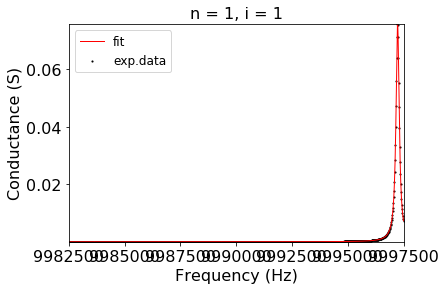

n = 7, band center = 69882000 Hz


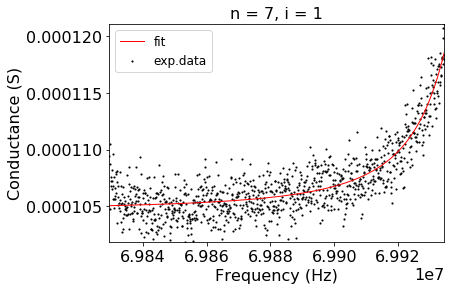

n = 11, band center = 109810000 Hz


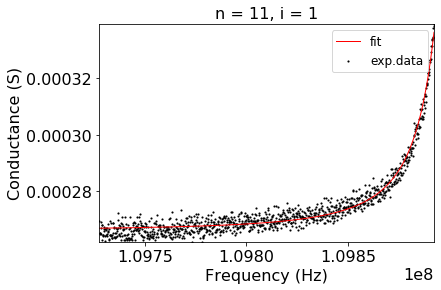

In [34]:
#loop over measurement number
for i in range(loops):
    
    print('measurement number '+format(i+1)+'/'+format(loops))
     
    #loop over harmonic number
    for n in range(len(h_list)):
    
        #estimate where resonance of harmonic will be
        band_cent = band_cent0*h_list[n] - 8000*(h_list[n]-1)
        print('n = '+format(h_list[n])+', band center = '+format(band_cent)+' Hz')
        
        #estimate width of the current resonance
        bandwidth0 = 15000 + 15000*(h_list[n]-1)
        
        
        
        #for first measurement at this harmonic
        if i == 0:
            #get frequency range to measure
            f_range = get_f_range(band_cent,
                                  band_points=band_points,
                                  bandwidth=bandwidth0)
        #for subsequent measurements at this harmonic
        if i > 0:
            #get frequency range to measure
            f_range = get_f_range(f_res_mat[i-1, n],
                                  band_points=band_points,
                                  bandwidth=bandwidth0)
           
        """
        #loop over frequency values to measure ------------------------------
        #standard implementation
        rs = [0]
        xs = [0]
        for f in range(band_points): 
            #measure Rs, Xs at specified frequency         
            device.measure(f_range[f], rs, xs)
            g = get_conductance(rs[0][0], xs[0][0])
            
            #populate matrices with frequency and conductance values
            f_mat[f,n,i] = f_range[f]
            g_mat[f, n,i] = g
        """
        #efficient implementation (uses half float so a bit less precise)
        rs = [0]*4
        xs = [0]*4
        for f in range(0, band_points, 4):
            #measure Rs, Xs at specified frequency
            sark110.measure_ext(f_range[f], f_range[f + 1] - f_range[f], rs, xs)

            #populate matrices with frequency and conductance values
            g = get_conductance(rs[0], xs[0])
            f_mat[f,n,i] = f_range[f]
            g_mat[f, n,i] = g
            g = get_conductance(rs[1], xs[1])
            f_mat[f+1,n,i] = f_range[f+1]
            g_mat[f+1, n,i] = g
            g = get_conductance(rs[2], xs[2])
            f_mat[f+2,n,i] = f_range[f+2]
            g_mat[f+2, n,i] = g
            g = get_conductance(rs[3], xs[3])
            f_mat[f+3,n,i] = f_range[f+3]
            g_mat[f+3, n,i] = g

        #remove points which are an artefact of bad sampling from SARK-110
        g_mat[:,n,i] = remove_outliers(g_mat[:,n,i])
            
        #calculate peak position and height
        f_res = f_range[np.argmax(g_mat[:,n,i])]
        f_res_mat[i, n] = f_res
        g_max = g_mat[np.argmax(g_mat[:,n,i]),n,i]
        f_mat_norm[:,n,i] = f_mat[:,n,i] - f_res
    
    
        #for first measurement at this harmonic, construct guess for RLC fit
        if i == 0: guess = [0,0, g_max, 1e-5, f_res]
        #for subsequent measurements, use previous fit params as guess    
        if i > 0: guess = param_mat[:,n,i-1]
            
            
        
        #window of curve to fit
        fit_win = 40-int(i/2)
        f_fit_win= f_mat[:np.argmax(g_mat[:,n,i])+fit_win, n, i]
        g_fit_win = g_mat[:np.argmax(g_mat[:,n,i])+fit_win, n, i]
        
        
        #fit data to lorentz peak
        fit_params,_ = curve_fit(single_lorentz,
                               f_fit_win,#f_mat[:,n,i],
                               g_fit_win,#g_mat[:,n,i],
                               bounds=(0,np.inf),
                               p0=guess)
        
        #populate matrix of fit parameters
        param_mat[:,n,i] = fit_params
        
        #calculate RLC from Burretworth Van Dyke equivalent circuit 
        R_mat[i,n], L_mat[i,n], C_mat[i,n] = single_RLC(fit_params)
        
        
        #calculate fitted curve
        g_fit = single_lorentz(f_mat[:,n,i],
                               *fit_params)
        
        
        
    
        
        #plot experimental data   
        plt.scatter(f_mat[:,n,i], g_mat[:,n,i], 
                    s=5, c = 'k', 
                    label='exp.data',
                    marker='.')
        #plot fit
        plt.plot(f_mat[:,n], g_fit, lw=1, c='r', label='fit')
        
        label_axes('Frequency (Hz)', 'Conductance (S)')
        plt.xlim([np.min(f_mat[:,n,i]),np.max(f_mat[:,n,i])])
        plt.ylim([np.min(g_mat[:,n,i]),np.max(g_mat[:,n,i])])
        plt.legend(fontsize=12)
        plt.title('n = '+format(h_list[n])+', i = '+format(i+1),fontsize=ls)
        plt.show()

        

In [35]:
sark110.close()